In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
#import pandas_datareader as pdr
import seaborn as sns; sns.set()
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np
from statsmodels.tsa.api import VAR
from numba import njit 
import sklearn.metrics

# Causality Detection: Granger Causality vs Transfer Entropy

The goal of this notebook is to stress the major limit of Granger Causality, i.e. the
failure to detect nonlinear causality interconnection between time series.

In [5]:
#Granger Causality routine

def grangers_causation_matrix(data, variables, maxlag = 12, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    results = []
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=verbose)
            results.append(test_result) #saving all the info available
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            # i stands for the lag, 0 for the dictionary with the statistics, test for the test, 1 for the
            #p value associated
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df,results


def GC(A,B,lag):
    
    data = pd.DataFrame(data = {'X' : A, 'Y': B})
    matrice, out = grangers_causation_matrix(data,data.columns,maxlag = lag,verbose=False)
    nobs = 4
    df = data
    df_train, df_test = df[0:-nobs], df[-nobs:]
    
    model1 = VAR(df_train)
    result = model1.fit(lag)
    noiseX_VAR = np.power(result.resid['X'],2).mean()
    noiseY_VAR = np.power(result.resid['Y'],2).mean()
    
    model2_X = AutoReg(data['X'], lag)
    model2_Y = AutoReg(data['Y'], lag)
    
    result_X = model2_X.fit()
    result_Y = model2_Y.fit()

    noiseX_AR = np.power(result_X.resid,2).mean()
    noiseY_AR = np.power(result_Y.resid,2).mean()
    
    GC_YcausesX = np.log(noiseX_AR/noiseX_VAR)
    GC_XcausesY = np.log(noiseY_AR/noiseY_VAR)
    #print((-noiseY_VAR+noiseY_AR))

    return matrice,GC_YcausesX,GC_XcausesY

def GCHeatMap(output,tp=False):
    
    L = len(output)
    index = [str(i+1) for i in np.arange(L)]
    label_index = [r'$X_'+str(i+1)+'$' for i in np.arange(L)]
    columns = index
    GC_tab = pd.DataFrame(np.zeros([L,L]),index = index , columns=columns)
    for j in np.arange(L):
        for i in np.arange(j):
            measure = GC(output[i],output[j],1)
            GC_tab[str(i+1)][str(j+1)] = measure[1]
            GC_tab[str(j+1)][str(i+1)] = measure[2]
    plt.figure(figsize=(10,10))
    ax = sns.heatmap(GC_tab, vmin=0, vmax=GC_tab.max().max(),linewidths=4,annot=True, fmt=".2f",cmap="YlGnBu",
                    annot_kws={"size": 20})
    title = 'Granger Causality HeatMap'
    plt.title(title,fontsize = 30)
    plt.yticks(np.arange(L)+0.5,label_index, rotation=0, fontsize="20",weight = 'bold', va="center")
    plt.xticks(np.arange(L)+0.5,label_index, rotation=0, fontsize="20",weight = 'bold', va="center")
    plt.ylim(L+0., -0.)
    if(tp):
        plt.savefig('Tesi/ImgTesi/GC'+tp+'.png')
    plt.show()
    return

In [6]:
def InteractionSystem(iterations = 200,linear = True):
    
    X = list(np.random.randn(5,1))
    X = [list(x) for x in X]
    if(linear): 
        l = 1
    else:
        l = 2
        
    for t in np.arange(iterations):
        x = [y[-1] for y in X]
        X[0].append(0.95*np.sqrt(2)*x[0]-0.9025*x[0] + np.random.randn())
        X[1].append(0.5*np.power(x[0],l)+np.random.randn())
        X[2].append(-0.4*x[0]+np.random.randn())
        X[3].append(-0.5*np.power(x[0],l)+0.25*np.sqrt(2)*x[3]+0.25*np.sqrt(2)*x[4]+np.random.randn())
        X[4].append(-0.25*np.sqrt(2)*x[3]+0.25*np.sqrt(2)*x[4]+np.random.randn())
    return X

def scatterPlot(output):
    
    L = len(output)
    f_scatter, ax = plt.subplots(L,L,figsize = (14,14))
    for i in np.arange(L):
        for j in np.arange(L):
            ax[i][j].scatter(output[i],output[j],alpha=0.7,color = 'blue',edgecolors='black')
            #ax[i][j].grid()
            if(j==0):
                ylabel = "$X_" + str(i) + "$"
                ax[i][j].set_ylabel(ylabel,size = 20)
            if(i == L-1 ):
                xlabel = "$X_" + str(j) + "$"
                ax[i][j].set_xlabel(xlabel,size = 20)
    plt.show()
    return 

In [7]:
# Transfer Entropy functions

@njit
def Entropy(pdf):
    
    return(-1/(pdf.shape[0])*np.sum(np.log2(pdf)))

def newData(X,m):

    return np.array([X[i-m:i] for i in np.arange(m,len(X)+1)])

def newDataMixed(X,Y,m):

    return np.array([[X[i-m:i],Y[i-m:i]] for i in np.arange(m,len(X)+1)])



def newDataMixedPlusOne(X,Y,m):
    
    return np.array([[X[i-m:i],Y[i-m:i],[X[i]] + [0 for i in np.arange(m-1)]] for i in np.arange(m,len(X))])
    


def KDE(X,Y=None, d=1,n_jobs=20):

    dists = sklearn.metrics.pairwise_distances(X, X, metric='chebyshev', n_jobs=n_jobs)
    pdf = (dists<d/2).mean(axis=1)
    return pdf/d

def TransferEntropyPlus(X,Y,m, resolution = .25):
    
    x = newData(X,m)
    y = newData(Y,m)

    xx = newData(X,m+1)
    yy = newData(Y,m+1)    

    xy = newDataMixed(X,Y,m)
    xy = xy.reshape(xy.shape[0], xy.shape[1]*xy.shape[2])

    xxy = newDataMixedPlusOne(X,Y,m)
    xxy = xxy.reshape(xxy.shape[0], xxy.shape[1]*xxy.shape[2])

    yyx = newDataMixedPlusOne(Y,X,m)
    yyx = yyx.reshape(yyx.shape[0], yyx.shape[1]*yyx.shape[2])
    
    Hxx =  Entropy(KDE(xx,d =resolution))
    Hx = Entropy(KDE(x,d = resolution))

    Hyy =  Entropy(KDE(yy,d = resolution))
    Hy = Entropy(KDE(y,d = resolution))

    Hxxy = Entropy(KDE(xxy,d = resolution))
    Hyyx = Entropy(KDE(yyx,d = resolution))

    Hxy =  Entropy(KDE(xy,d = resolution))

    T_yx = Hxx-Hx-(Hxxy-Hxy)
    T_xy = Hyy-Hy-(Hyyx-Hxy)
    
    return T_xy,T_yx

def TEHeatMap(output,m = 1,res = 2,tp = False):

    L = len(output)
    index = [str(i+1) for i in np.arange(L)]
    label_index = [r'$X_'+str(i+1)+'$' for i in np.arange(L)]
    columns = index
    TE_tab = pd.DataFrame(np.zeros([L,L]),index = index , columns=columns)
    for j in np.arange(L):
        for i in np.arange(j):
            measure = TransferEntropyPlus(output[i],output[j],m, resolution = res)
            TE_flow = measure[0] - measure[1]
            TE_tab[str(i+1)][str(j+1)] = measure[1]
            TE_tab[str(j+1)][str(i+1)] = measure[0]
    plt.figure(figsize=(10,10))
    ax = sns.heatmap(TE_tab, vmin=0, vmax=TE_tab.max().max(),linewidths=4,annot=True, fmt=".2f",cmap="YlGnBu",
                    annot_kws={"size": 20})
    title = 'TE HeatMap'
    plt.title(title,fontsize = 30)
    plt.yticks(np.arange(L)+0.5,label_index, rotation=0, fontsize="20",weight = 'bold', va="center")
    plt.xticks(np.arange(L)+0.5,label_index, rotation=0, fontsize="20",weight = 'bold', va="center")
    plt.ylim(L+0., -0.)
    if(tp):
        plt.savefig('Tesi/ImgTesi/TE'+tp+'.png')
    plt.show()
    return

# Linear Regime
\begin{array}{l}
x_{1}(n)=0.95 \sqrt{2} x_{1}(n-1)-0.9025 x_{1}(n-1)+w_{1} \\
x_{2}(n)=0.5 x_{1}(n-1)+w_{2} \\
x_{3}(n)=-0.4 x_{1}(n-1)+w_{3} \\
x_{4}(n)=-0.5 x_{1}(n-1)+0.25 \sqrt{2} x_{4}(n-1)+0.25 \sqrt{2} x_{5}(n-1)+w_{4} \\
x_{5}(n)=-0.25 \sqrt{2} x_{4}(n-1)+0.25 \sqrt{2} x_{5}(n-1)+w_{5}\\
\text{where } w_i \sim N(0,1) 
\end{array}

![title](img/Linear.png)

Graph showing all the coupling (linear) between time-series

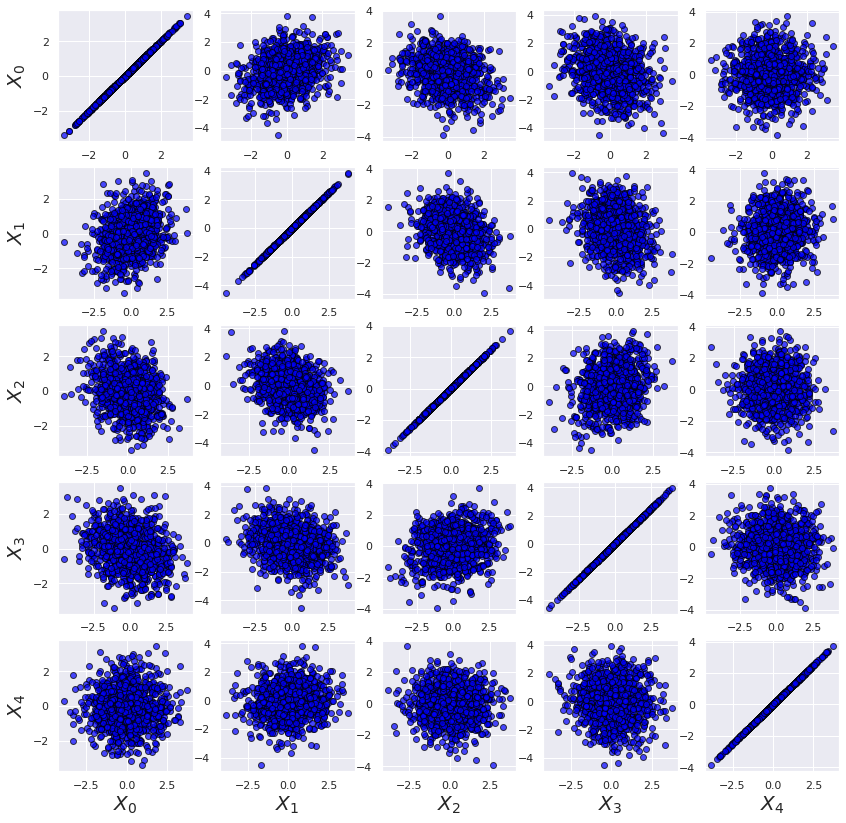

/home/gianluca/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/home/gianluca/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/home/gianluca/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/home/gianluca/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new n

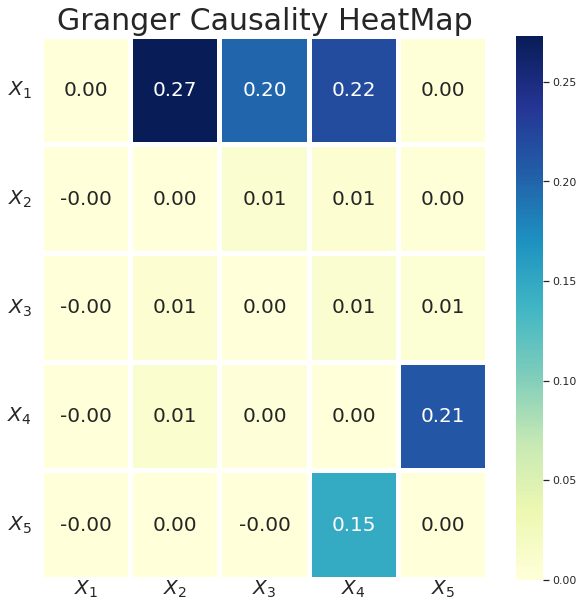

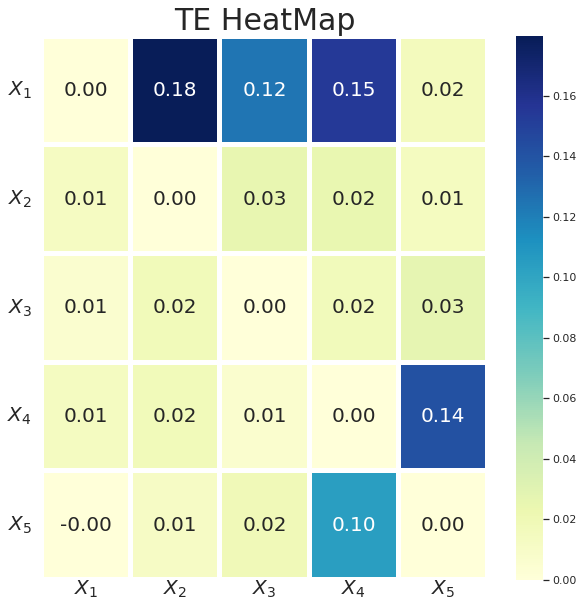

In [8]:
linear_interactions = InteractionSystem(10**3)
scatterPlot(linear_interactions)
GCHeatMap(linear_interactions,tp='linear')
TEHeatMap(linear_interactions,res=2,tp = 'linear')

We can see how both the analysis succeed to detect all
the dependencies of the system: $x_1$ is found to drive $x_2$ , $x_3$ , $x_4$ , and $x_4$ and $x_5$ to
drive each other mutually

# Non-Linear Regime


\begin{array}{l}
x_{1}(n)=0.95 \sqrt{2} x_{1}(n-1)-0.9025 x_{1}(n-1)+w_{1} \\
x_{2}(n)=0.5 x_{1}^2(n-1)+w_{2} \\
x_{3}(n)=-0.4 x_{1}(n-1)+w_{3} \\
x_{4}(n)=-0.5 x_{1}^2(n-1)+0.25 \sqrt{2} x_{4}(n-1)+0.25 \sqrt{2} x_{5}(n-1)+w_{4} \\
x_{5}(n)=-0.25 \sqrt{2} x_{4}(n-1)+0.25 \sqrt{2} x_{5}(n-1)+w_{5}\\
\text{where } w_i \sim N(0,1) 
\end{array}

![title](img/NonLinear.png)

Graph showing all the couplings between time-series. In red non-linear coupling

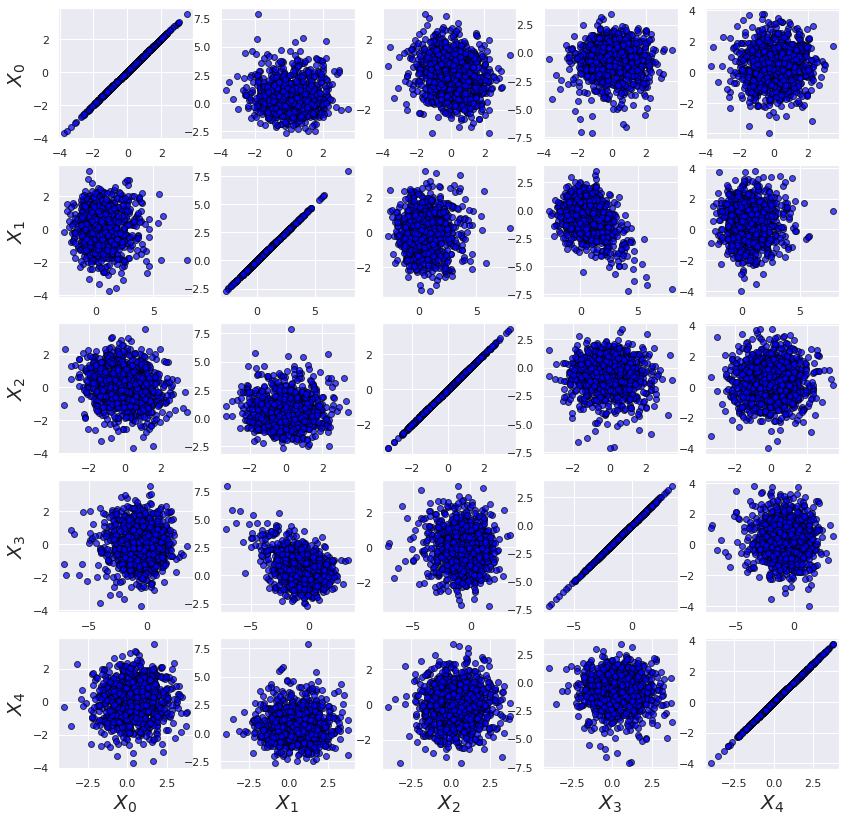

/home/gianluca/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/home/gianluca/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/home/gianluca/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/home/gianluca/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new n

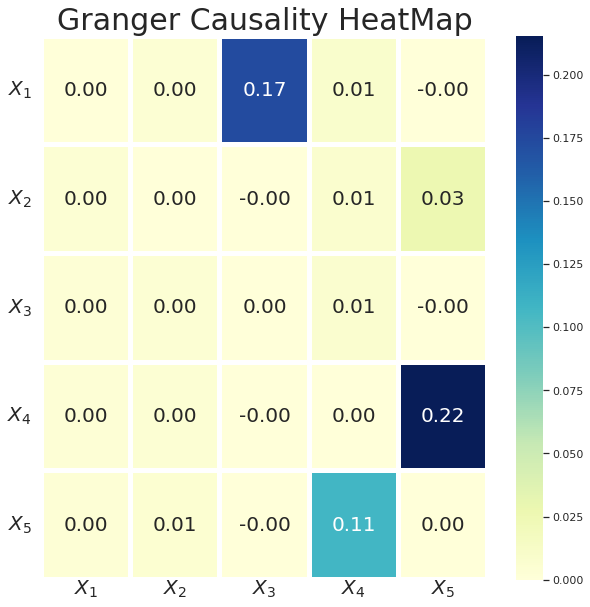

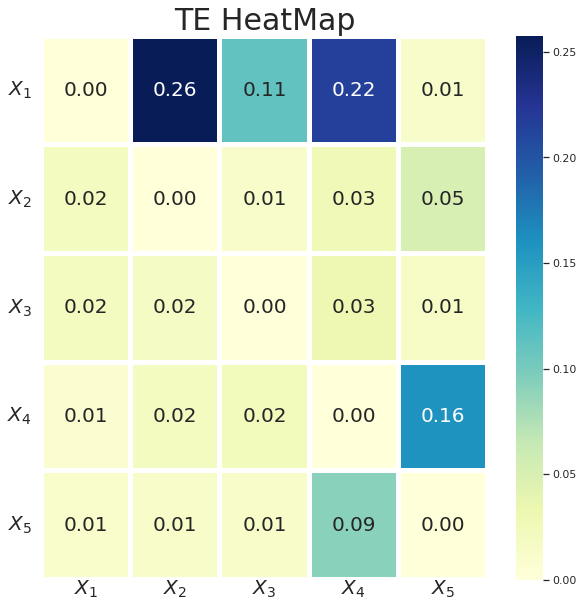

In [9]:
nonLinear_interactions = InteractionSystem(1000,False)
scatterPlot(nonLinear_interactions)
GCHeatMap(nonLinear_interactions,tp='Nonlinear')
TEHeatMap(nonLinear_interactions,res=2,tp='Nonlinear')


Differently from the previous case, we clearly see a different
response of the Granger Causality to the non-linearity added. This is not the case

of the detection based on TE, which still measures a causality relation between $x_1$
and $x_2$ , and $x_1$ and $x_4$ .